# Generative model using Wavelet Scattering Transform moments matching

## Introduction

In this notebook I illustrate the use of *wavelet scattering moments* to generate new images based on one example only (*one-shot learning*). Wavelet scattering moments are a set of statistics based on multi-scale wavelet features which have interesting properties such as translation covariance (or invariance if we sum some coefficients), stability under small deformations and scalable complexity (you add the same number of coefficients each time you double the size of the input). They are typically good to characterize textures which can be though of stationary stochastic processes.

The model is interpretable and completely deterministic as the weights are set in advance from wavelet functions. We use one example image, $x_0$, to measure the corresponding scattering moments, $S_0 = S(x_0)$, and use two strategies to generate new images (new samples):

1. Start from a white noise image and apply a gradient descent to steer the image towards the same scattering moments as the example image. In the literature, this is knwon as the *microcanonial* model. This is simple to implement but difficult to converge for certain types of images.

2. Build a maximum-entropy model where new samples are drawn from a Boltzmann distibution with the scattering moments playing the role of the conjugated variable with respect to some constraints. For example, one moment can be an energy associated to a temperature. This is known as a *macrocanonical* model. The principal issue is that we don't know the normalization factor (partition function), so we need to apply a Markov Chain Monte Carlo algorithm to sample new realisations. ⚠️ *This is a work in progress*

This work is based on the following papers:

* https://hal.science/hal-02093364/document
* https://epubs.siam.org/doi/pdf/10.1137/19M1307731
* (French) https://www.college-de-france.fr/fr/agenda/seminaire/modeles-information-et-physique-statistique/synthese-images-par-maximum-entropie

We need to have the `kymatio` package installed. See https://www.kymat.io/.

In [1]:
import datetime

import numpy as np

from skimage import io
from skimage.util import img_as_float32, img_as_ubyte

import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Selecting {device} as computing device.')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

Selecting cuda as computing device.


## Load examples

We can try examples from histology slides, turbulence, various textures. Images are stored in the `inputs` folder. They should be greyscale. The loose naming convention is:
- [no prefix]: 512x512 pixels
- `_small`: 256x256
- `_tiny`: 128x128
- `_nano`: 64x64

In [2]:
# 
files = [
    'inputs/histology1_tiny.tiff',
    'inputs/histology3_tiny.tiff',
    'inputs/isotropic_turbulence_tiny.tiff',
    'inputs/shirt_tiny.tiff',
    'inputs/ifm_tiny.tiff',
]


In [3]:
images = []
for name in files:
    images.append(img_as_float32(io.imread(name)))

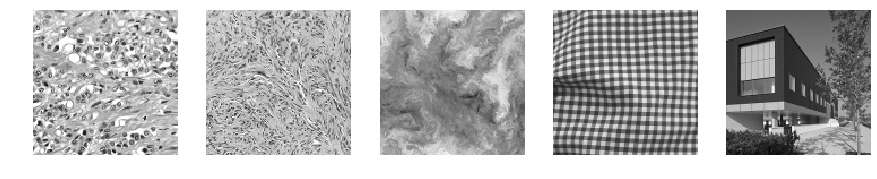

In [4]:
plt.rcParams["figure.figsize"] = (15,5)
figure, ax = plt.subplots(ncols=len(images))
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray', vmin=0, vmax=1)
    ax[i].axis('off')
plt.show()

## Define scattering moments

Because we want a translation-invariant model, the wavelet decomposition is performed for all scales `J` in order to get the average value as the output of the scattering transform. See https://www.kymat.io/userguide.html. `L` is the number of scattering angles. 

In [5]:
# Define Wavelet Scattering Transform
print("Defining WST (this step can be slow)...")
L = 4
J = int(np.log2(images[0].shape[0])) # Full scale for stationary processes
print(J)
wst = Scattering2D(J, images[0].shape, L=L)
wst = wst.cuda()

def S(x):
    """Define scattering transform"""
    return wst(x).flatten()

Defining WST (this step can be slow)...
7


## Micro-canonical method

In this method, we generate a new texture, $x_1$, such that:
$$
x_1 = \arg \min_{x}\left(|S(x)-S(x_0)|  \right)
$$
where $S(x)$ is the scattering transform and $x_0$ is the example image. In other words, we use an optimization process so that $x_1$ has the same scattering moments as the example. 

This is a non-convex problem and therefore turns out to be very difficult in practice. Optimizer type, meta-parameters, initialization, etc. play a crucial role.

To be close to a maximum entropy model, we would like to start the optimitation with a uniform noise. By experimenting I found that this leads to very slow convergence near the bottom right: I have no idea why! So instead we can start from a filtered noise which has the same power spectrum density (PSD) as the example.

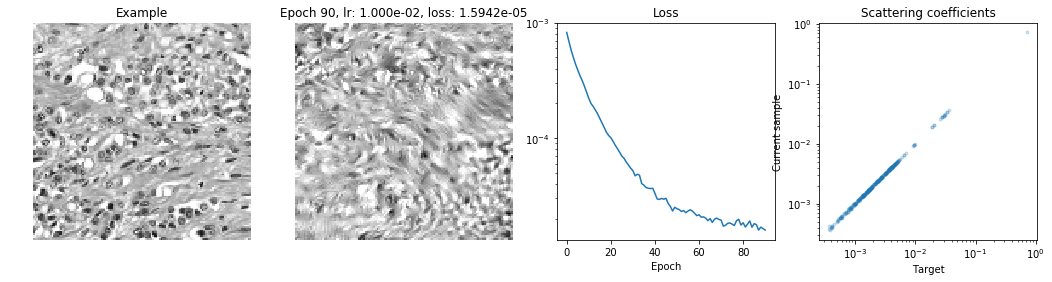

In [6]:
# Select image number
i = 0

# Compute scattering transform of the example
image = images[i]
S0 = S(torch.from_numpy(image).to(device).contiguous())

S0_plot = S0.detach().cpu()



# Create trainable image
# ----------------------

# From random values
x = torch.rand(image.shape, requires_grad=True, device=device)

# From low noise
#x = torch.full(image.shape, 0.5, requires_grad=True, device=device)
#with torch.no_grad():
#    x += 0.1*torch.randn(image.shape, device=device)
    

# Optional: randomized matching power spectrum density
pre_filter = True
if pre_filter:
    with torch.no_grad():
        # Noise
        x_hat = torch.fft.fft2(x)
        x_psd = torch.abs(x_hat)**2
        # Example
        psd0 = torch.abs(torch.fft.fft2(torch.from_numpy(image).to(device).contiguous()))**2
        # Filter
        x_hat2 = x_hat*torch.sqrt(psd0/x_psd)
        # Inverse
        x = torch.real(torch.fft.ifft2(x_hat2)).contiguous()
    x.requires_grad_()


# Optimizer
# ---------
optimizer = optim.Adam([x], lr=0.01)
#optimizer = optim.SGD([x], lr=1e4, momentum=0.9, dampening=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100)

# Optional: annealing (introduces noise in the optimizer)
annealing = False
if annealing:
    # Noise tensor
    W = torch.randn(image.shape, device=device)


# Optimization loop
# -----------------
max_iter = 100
losses = []

for epoch in range(max_iter):
    S1 = S(x)
    #loss = F.mse_loss(input=S1, target=S0)
    loss = F.l1_loss(input=S(x), target=S0)
    loss.backward()
    optimizer.step()
    
    if annealing:
        with torch.no_grad():
            # Add updated random noise
            x += np.sqrt(2*optimizer.param_groups[0]['lr']*0.1/np.sqrt(0.1*epoch+1))*W.normal_()
    
    optimizer.zero_grad()
    scheduler.step(loss.item())
    losses.append(loss.item())
    
    if epoch%10==0:
        # Plotting
        current_image = x.detach().cpu().numpy()
        clear_output(wait=True)
        
        
        plt.rcParams["figure.figsize"] = (18,4)
        figure, ax = plt.subplots(ncols=4)
        ax[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        ax[0].set_title("Example")
        ax[0].axis('off')

        ax[1].imshow(current_image, cmap='gray', vmin=0, vmax=1)
        #ax[1].set_title(f"Epoch {epoch}, lr: {scheduler.get_last_lr()[0]:1.6f}, loss: {loss.item():1.3e}")
        ax[1].set_title(f"Epoch {epoch}, lr: {scheduler._last_lr[0]:1.3e}, loss: {loss.item():1.4e}")
        ax[1].axis('off')

        if len(losses) < 50:
            ls = 'o-'
        else:
            ls = '-'
        ax[2].semilogy(losses, ls)
        ax[2].set_xlabel('Epoch')
        ax[2].set_title('Loss')
        
        
        ax[3].loglog(S0_plot, S1.detach().cpu(), '.', alpha=0.2)
        ax[3].set_title('Scattering coefficients')
        ax[3].set_xlabel('Target')
        ax[3].set_ylabel('Current sample')
        plt.show()

## Save image

In [7]:
now = datetime.datetime.now()

x1 = x.detach().cpu().numpy()
x1[x1>1] = 1
x1[x1<0] = 0
io.imsave(f'outputs/{now.strftime("%Y-%m-%d %H:%M:%S")}_J{J}_L{L}_output.tiff', img_as_ubyte(x1))

## Macro-canonical method (work in progress)

Now the scattering moments are used as variables of a maximum-entropy model. The probability of sampling a given image $x$ is assumed to be:
$$
P(x) \propto e^{-\beta \cdot S(x)}
$$
where $\beta$ is the vector of Lagrange multiplyers. We don't know $\beta$ and we don't know the normalization factor of the distribution, so we are going to apply a Markov Chain Monte Carlo (MCMC) method to jointly solve this problem. As described by De Bortoli *et al.*, this is an iterative process with two inner steps:

1. Sample images using an overdamped Langevin algorithm (https://en.wikipedia.org/wiki/Brownian_dynamics): 
$$
x_{n+1} = x_n -\gamma \beta \cdot \nabla_x S(x_n) + \sqrt{2\gamma}W_{n+1}
$$
with $\gamma$ a step (in units of m² in Brownian dynamics), $W$ a white noise. From the mechanical analogy, the gradient term will force the scattering coefficients towards lower values, while the noise will keep them at a certain level.

2. When step one has converged towards a stationary process, use the samples to calculate the empirical average $\langle S(x) \rangle$ and update the Lagrange multiplyers so that $\langle S(x) \rangle$ tends towards $S(x_0)$:
$$
\beta_{n+1} = \beta_n + \delta \left( \langle S(x) \rangle - S(x_0)  \right)
$$
where $\delta$ is the step.

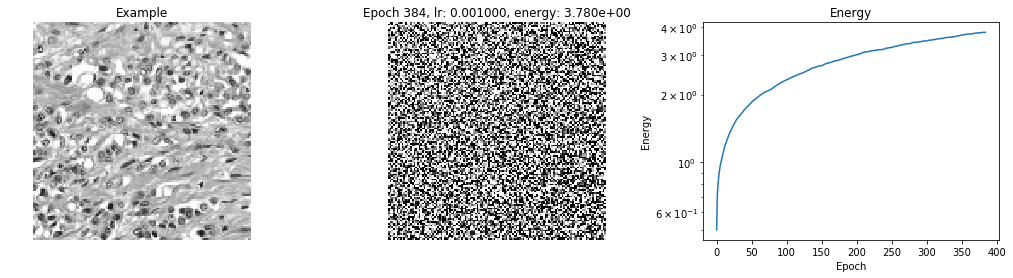

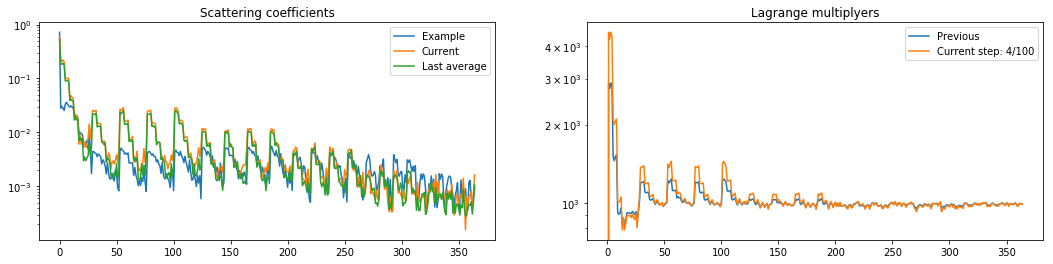

KeyboardInterrupt: 

In [8]:
# Select image number
i = 0

# Compute scattering transform of the example
image = images[i]


S0 = S(torch.from_numpy(image).to(device).contiguous())
S0_plot = S0.detach().cpu().numpy()

# Start with uniform beta
beta = 1000*torch.ones(len(S0), device=device)
beta_old = beta.cpu()

# Noise tensor
W = torch.randn(image.shape, device=device)

# Start with random image
#x = torch.rand(image.shape, requires_grad=True, device=device)

# Or start with uniform image
x = torch.full(image.shape, 0.5, requires_grad=True, device=device)

# Or start from example:
#x = torch.tensor(image, requires_grad=True, device=device)

optimizer = optim.SGD([x], lr=0.001)  # Note that the learning rate (lr) also governs the level of noise.
equilibrium_iter = 10 # Number of steps before stationarity is assumed
take_every = 10 # Take every other sample to calculate average, rest is discarded
num_sample = 10 # Number of samples to collect before updating Lagrange multiplyers
sample_avg = None  #Will be populated with scattering average

# Record energy
energies = []
epoch = 0


# Step for Lagrange multiplyers update
delta = 10000.

# Number of updates
num_outer = 100


# Start outer loop
for outer in range(num_outer):

    samples = []
    
    # Inner loop
    for inner in range(equilibrium_iter + take_every*(num_sample-1) + 1):

        epoch += 1
        # Compute current energy
        S1 = S(x)
        loss = torch.sum(beta*S1)

        # Compute and apply deterministric force
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            # Add updated random noise
            x += np.sqrt(2*optimizer.param_groups[0]['lr'])*W.normal_()

            # Crop at both ends
            #x[x>1] = 1
            #x[x<0] = 0

            # Bounce at both ends
            #x[x>1] = 2 - x[x>1]
            #x[x<0] = - x[x<0]


        energies.append(np.sum(S1.detach().cpu().numpy()))

        # Collecting samples
        collecting_i = inner - equilibrium_iter
        collecting = collecting_i >-1 and collecting_i%take_every==0
        if collecting:
            samples.append(S1.detach().cpu().numpy())

        # Plotting
        if inner%10 == 0 or collecting:
            current_img = x.detach().cpu().numpy()
            S1_plot = S1.detach().cpu().numpy()

            clear_output(wait=True)
            figure, ax = plt.subplots(ncols=3)
            ax[0].imshow(image, cmap='gray', vmin=0, vmax=1)
            ax[0].set_title("Example")
            ax[0].axis('off')

            ax[1].imshow(current_img, cmap='gray', vmin=0, vmax=1)
            # ax[1].set_title(f"Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:1.6f}, loss: {loss.item():1.3e}")
            ax[1].set_title(f"Epoch {epoch}, lr: {optimizer.param_groups[0]['lr']:1.6f}, energy: {energies[-1]:1.3e}")
            ax[1].axis('off')

            if len(energies) < 50:
                ls = 'o-'
            else:
                ls = '-'
            ax[2].semilogy(energies, ls)
            ax[2].set_xlabel('Epoch')
            ax[2].set_ylabel('Energy')
            ax[2].set_title('Energy')
            plt.show()

            figure, ax = plt.subplots(ncols=2)
            ax[0].semilogy(S0_plot, label='Example')
            ax[0].semilogy(S1_plot, label='Current')
            if sample_avg is not None:
                ax[0].semilogy(sample_avg, label='Last average')
            ax[0].legend()
            ax[0].set_title('Scattering coefficients')

            ax[1].set_title('Lagrange multiplyers')
            ax[1].semilogy(beta_old, label='Previous')
            ax[1].semilogy(beta.cpu(), label=f'Current step: {outer+1}/{num_outer}')
            ax[1].legend()

        #    ax[3].hist(best_img.flatten(), np.linspace(0,1,100), density=True)
        #    ax[3].set_title('Histogram')

        #    ax[3].semilogy(S1_plot, label='Current sample')
        #    ax[3].semilogy(S0_plot, label='Example')
        #    ax[3].set_xlabel('Coefficients')
        #    ax[3].set_ylabel('Value')
        #    ax[3].legend()
            plt.show()
            
    # Now that we have collected samples, perform the average
    sample_avg = np.average(np.array(samples), axis=0)
    
    print(f'Maximum beta increment: {delta*np.amax(np.abs(sample_avg- S0_plot))}')
    
    # And update Lagrange multiplyers:
    beta_old = beta.cpu()
    beta += delta*(torch.tensor(sample_avg, device=device) - S0) 